# Welcome back to the hellish purgatory in which I reside

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.visualization import quantity_support
quantity_support()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm, TwoSlopeNorm
import pandas as pd
pd.set_option("display.max_columns", None)

import thor
from thor.constants import Constants
from thor.backend import PYOORB
backend = PYOORB()

import urllib.request, json 

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Example from NEOCP

Use data from an example observation from the NEOCP

In [4]:
WHICH_EXAMPLE = "P21vBEn"

In [5]:
data_times = []
data_coords = []

with open(f"examples/{WHICH_EXAMPLE}.obs", "r") as file:
    for line in file:
        date = line[15:32].split()
        obstime = Time(date[0] + "-" + date[1] + "-" + date[2].split(".")[0]) + float("0." + date[2].split(".")[1])
        data_times.append(obstime)
        
        data_coords.append(SkyCoord(ra=line[32:44], dec=line[44:56], unit=(u.hourangle, u.deg), frame="icrs"))
        
delta_t = (data_times[-1] - data_times[0]).to(u.day)

The following cell gives the nominal position of the object at the future time
I got this by
- getting ephemeris of NEOCP object
- getting offsets for the chosen time
- choose the first (nominal) variant orbit
- copy the ra/dec/time into a file

In [6]:
nominal_df = pd.read_csv(f"examples/{WHICH_EXAMPLE}.nominal")
nominal = SkyCoord(ra=nominal_df["ra"][0], dec=nominal_df["dec"][0], unit=(u.hourangle, u.deg))

# Actual calculations

In [7]:
def variant_orbit_ephemerides(ra, dec, ra_end, dec_end, delta_t, obstime, distances, radial_velocities,
                              sigma_ra=0.1 * u.arcsecond, sigma_dec=0.1 * u.arcsecond, eph_times=None,
                              coords="heliocentriceclipticiau76", location="Gemini South", obs_code="I11",
                              pm_ra_cosdec=None, pm_dec=None, verbose=False):
    """Generate ephemerides for a series of variant orbits for an observed object without constraints on its
    distance and radial velocity.

    Parameters
    ----------
    ra : `float`
        Right ascension at initial observation (with Astropy units)
    dec : `float`
        Declination at initial observation (with Astropy units)
    obstime : `Astropy Time object`
        Time of initial observation
    ra_end : `float`
        Right ascension at final observation (with Astropy units)
    dec_end : `float`
        Declination at final observation (with Astropy units)
    delta_t : `Astropy Time object`
        Time between observations
    pm_ra_cosdec : `float`, optional
        Directly calculated change in dot(ra) * cos(dec) (replaces ra_end, dec_end, delta_t), by default None
    pm_dec : `float`, optional
        Directly calculated change in dot(dec) (replaces ra_end, dec_end, delta_t), by default None
    distances : `float/array`
        Array of possible distances to use
    radial_velocities : `float/array`
        Array of possible radial velocities to use
    sigma_ra : `float`, optional
        Observation error in RA, by default 0.1*u.arcsecond
    sigma_dec : `float`, optional
        Observation error in Dec, by default 0.1*u.arcsecond
    eph_times : `Astropy Time object/array`, optional
        Array of times at which to produce ephemerides, by default 1 day later
    coords : `str`, optional
        Coordinate system to use, by default "heliocentriceclipticiau76"
    location : `str`, optional
        Location of observations (str from astropy Earth locations), by default "Gemini South"a
    obs_code : `str`, optional
        As `location` for the 3 character code, by default "I11"
    verbose: `bool`, optional
        Whether to print some debugging messages, by default False

    Returns
    -------
    df : `pandas DataFrame`
        Dataframe containing ephemerides for each distance-radial velocity combination

    """

    # create a grid from the distances and radial velocities
    D, RV = np.meshgrid(distances, radial_velocities)
    size = len(distances) * len(radial_velocities)

    # use astropy to get information based on a site name
    obs_loc = EarthLocation.of_site(location)

    # need a list with units rather than list of things each with units
    obsgeoloc = [x.to(u.m).value for x in obs_loc.geocentric] * u.m

    # get the observer position in cartesian GCRS coordinates for THOR
    observer_position = SkyCoord(x=obsgeoloc[0],
                                 y=obsgeoloc[1],
                                 z=obsgeoloc[2],
                                 obstime=obstime,
                                 frame="gcrs",
                                 representation_type="cartesian").transform_to(coords).cartesian.xyz.to(u.AU).value
    observer_positions = np.tile(observer_position, (size, 1))

    # if proper motions are not provided
    if pm_ra_cosdec is None and pm_dec is None:
        # add some dispersion to the ra/dec's with the given sigmas (or just repeat if not are given)
        if sigma_ra.value == 0.0:
            ra = np.repeat(ra.value, repeats=size) * ra.unit
            ra_end = np.repeat(ra_end.value, repeats=size) * ra_end.unit
        else:
            ra = np.random.normal(ra.value, scale=sigma_ra.to(ra.unit).value, size=size) * ra.unit
            ra_end = np.random.normal(ra_end.value, scale=sigma_ra.to(ra_end.unit).value, size=size) * ra_end.unit

        if sigma_dec.value == 0.0:
            dec = np.repeat(dec.value, repeats=size) * dec.unit
            dec_end = np.repeat(dec_end.value, repeats=size) * dec_end.unit
        else:
            dec = np.random.normal(dec.value, scale=sigma_dec.to(dec.unit).value, size=size) * dec.unit
            dec_end = np.random.normal(dec_end.value, scale=sigma_dec.to(dec_end.unit).value, size=size) * dec_end.unit

        # convert them to Skycoords
        start = SkyCoord(ra=ra, dec=dec, frame="icrs")
        end = SkyCoord(ra=ra_end, dec=dec_end, frame="icrs")

        # calculate the offset in ra/dec and convert to a proper motion
        delta_ra_cosdec, delta_dec = start.spherical_offsets_to(end)
        pm_ra_cosdec, pm_dec = delta_ra_cosdec / delta_t, delta_dec / delta_t

        if verbose:
            print(ra, dec, ra_end, dec_end, delta_t, pm_ra_cosdec, pm_dec)

    # put it all together into a single astropy SkyCoord in GCRS (using loc/time from above)
    coord = SkyCoord(ra=ra,
                     dec=dec,
                     pm_ra_cosdec=pm_ra_cosdec,
                     pm_dec=pm_dec,
                     distance=D.ravel(),
                     radial_velocity=RV.ravel(),
                     frame="gcrs",
                     obsgeoloc=obsgeoloc,
                     obstime=obstime)
    
    # convert to ecliptic
    ecl = coord.transform_to(coords)

    # translate astropy into what THOR wants
    orbits = np.atleast_2d(np.concatenate((ecl.cartesian.xyz.to(u.AU).value,
                                           ecl.velocity.d_xyz.to(u.AU / u.day).value))).T
    t0 = np.repeat(ecl.obstime.mjd, size)

    # use THOR to account for light travel time
    corrected_orbits, lt = thor.addLightTime(orbits=orbits, t0=t0, observer_positions=observer_positions,
                                             lt_tol=1e-10, mu=Constants.MU, max_iter=1000, tol=1e-15)
    corrected_t0 = t0 - lt

    # create a THOR orbits class
    orbits_class = thor.Orbits(orbits=corrected_orbits, epochs=Time(corrected_t0, format="mjd"))

    # default to one day after the observation
    if eph_times is None:
        eph_times = np.atleast_1d(obstime + 1)

    # use pyoorb (through THOR) to get the emphemeris at the supplied times
    df = backend.generateEphemeris(orbits=orbits_class, observers = {obs_code: eph_times})

    return df

In [8]:
def create_scout_comparison_plot(day, time, des="P21vBEn", distances=None, radial_velocities=None,
                                 obs_code="F52", location="Haleakala Observatories", **kwargs):

    print("Loading in observation data from Scout...")

    # load in the Scout observation data about this object in MPC format
    with urllib.request.urlopen(f"https://ssd-api.jpl.nasa.gov/scout.api?tdes={des}&file=mpc") as url:
        file = json.loads(url.read().decode())["fileMPC"]

        scout_times = []
        scout_coords = []

        for line in file.split("\n"):
            if line.rstrip() != "":
                date = line[15:32].split()
                obstime = Time(date[0] + "-" + date[1] + "-" + date[2].split(".")[0])\
                    + float("0." + date[2].split(".")[1])
                scout_times.append(obstime)

                scout_coords.append(SkyCoord(ra=line[32:44], dec=line[44:56],
                                             unit=(u.hourangle, u.deg), frame="icrs"))

        # NOTE: this currently just naively takes the first and last observation
        scout_delta_t = (scout_times[-1] - scout_times[0]).to(u.day)

    print("Computing and loading ephemerides from Scout...")

    # get the ephemeris information from Scout
    url_str = f"https://ssd-api.jpl.nasa.gov/scout.api?tdes={des}&eph-start={day}T{time}&obs-code={obs_code}"
    with urllib.request.urlopen(url_str) as url:
        data = json.loads(url.read().decode())

        # nominal comparison orbit (I think this is the median in Scout)
        nominal = SkyCoord(ra=float(data["eph"][0]["median"]["ra"]),
                           dec=float(data["eph"][0]["median"]["dec"]), unit="deg", frame="icrs")

        # ephemeris (taking only the ra/dec/magnitude)
        scout_eph = np.array(data["eph"][0]["data"])[:, [0, 1, 4]].astype(float)

    print("Computing orbits using Tom's variant orbit code...")
    if distances is None:
        distances = np.logspace(np.log10(6e-2), np.log10(2), 500) * u.AU
    if radial_velocities is None:
        radial_velocities = np.linspace(-30, 30, 20) * u.km / u.s
    D, RV = np.meshgrid(distances, radial_velocities)

    df = variant_orbit_ephemerides(ra=scout_coords[0].ra,
                                   dec=scout_coords[0].dec,
                                   ra_end=scout_coords[-1].ra,
                                   dec_end=scout_coords[-1].dec,
                                   delta_t=scout_delta_t,
                                   obstime=scout_times[0],
                                   distances=distances,
                                   radial_velocities=radial_velocities,
                                   eph_times=np.atleast_1d(Time(f"{day} {time}")),
                                   obs_code=obs_code,
                                   location=location,
                                   **kwargs)

    print("Done. Plotting!")

    # create a figure
    fig, ax = plt.subplots(figsize=(16, 10))

    # scatter the variant orbits created with this code
    scatter = ax.scatter((df["RA_deg"] - nominal.ra.to(u.deg).value) * np.cos(nominal.dec.to(u.deg)) * (u.deg).to(u.arcminute),
                         (df["Dec_deg"] - nominal.dec.value) * (u.deg).to(u.arcminute),
                         s=5, c=D.ravel(), norm=LogNorm(), cmap="Reds_r")

    first_xlims = ax.get_xlim()
    first_ylims = ax.get_ylim()

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("Assumed Distance [AU]")

    # scatter the orbits using Scout
    scout = ax.scatter((scout_eph.T[0] - nominal.ra.value) * np.cos(nominal.dec.to(u.deg)) * (u.deg).to(u.arcminute),
                       (scout_eph.T[1] - nominal.dec.value) * (u.deg).to(u.arcminute),
                       s=10, c=scout_eph.T[2], cmap="rainbow", label="Scout Data")

    second_cbar = fig.colorbar(scout, ax=ax)
    second_cbar.set_label("V-band Magnitude")

    ax.set_xlabel("Relative RA cos(dec) [arcminutes]")
    ax.set_ylabel("Relative Declination [arcminutes]")

    ax.set_xlim(min(first_xlims[0], ax.get_xlim()[0]), max(first_xlims[1], ax.get_xlim()[1]))
    ax.set_ylim(min(first_ylims[0], ax.get_ylim()[0]), max(first_ylims[1], ax.get_ylim()[1]))

    ax.set_xlim(reversed(ax.get_xlim()))

    ax.annotate(f"RV range used: [{RV.min()}, {RV.max()}]", xy=(0.95, 0.05),
                xycoords="axes fraction", ha="right", fontsize=0.8*fs)

    ax.set_title(des, fontsize=fs)

    ax.legend(loc="upper left", handletextpad=0, markerscale=5)

    ax.grid()

    plt.show()
    
    return df, scout_eph, nominal

In [10]:
df, scout_eph, nominal = create_scout_comparison_plot("2022-08-03", "23:00:00")

Loading in observation data from Scout...


KeyError: 'fileMPC'

Loading in observation data from Scout...
Computing and loading ephemerides from Scout...
Computing orbits using Tom's variant orbit code...
Done. Plotting!


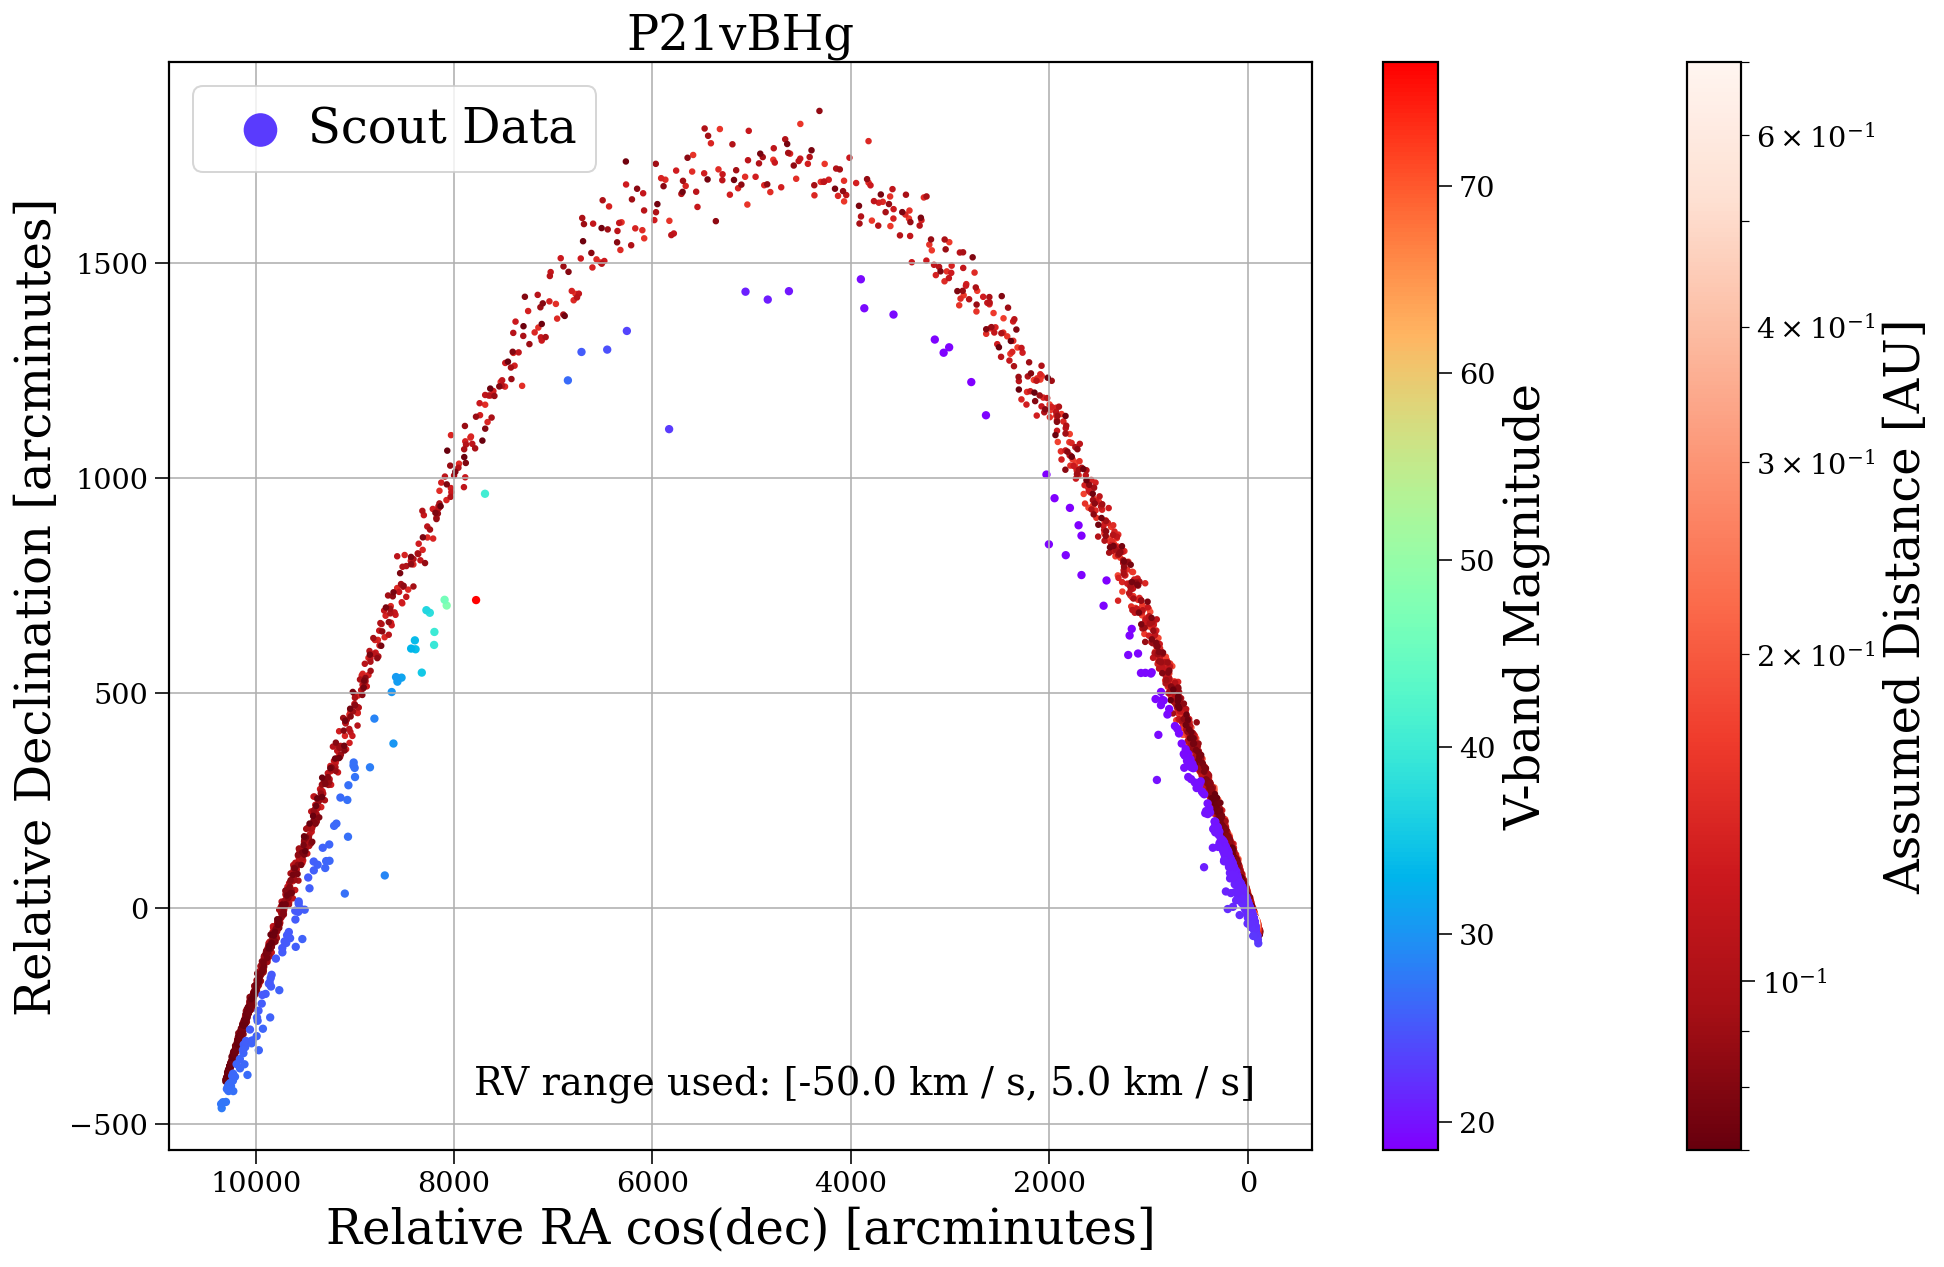

In [441]:
df, scout_eph, nominal = create_scout_comparison_plot("2022-08-03", "23:00:00", des="P21vBHg",
                             sigma_ra=1 * u.arcsecond, sigma_dec=1 * u.arcsecond,
                             distances=np.logspace(np.log10(7e-2), np.log10(7e-1), 500) * u.AU,
                             radial_velocities=np.linspace(-50, 5, 20) * u.km / u.s)

Loading in observation data from Scout...
Computing and loading ephemerides from Scout...
Computing orbits using Tom's variant orbit code...
Done. Plotting!


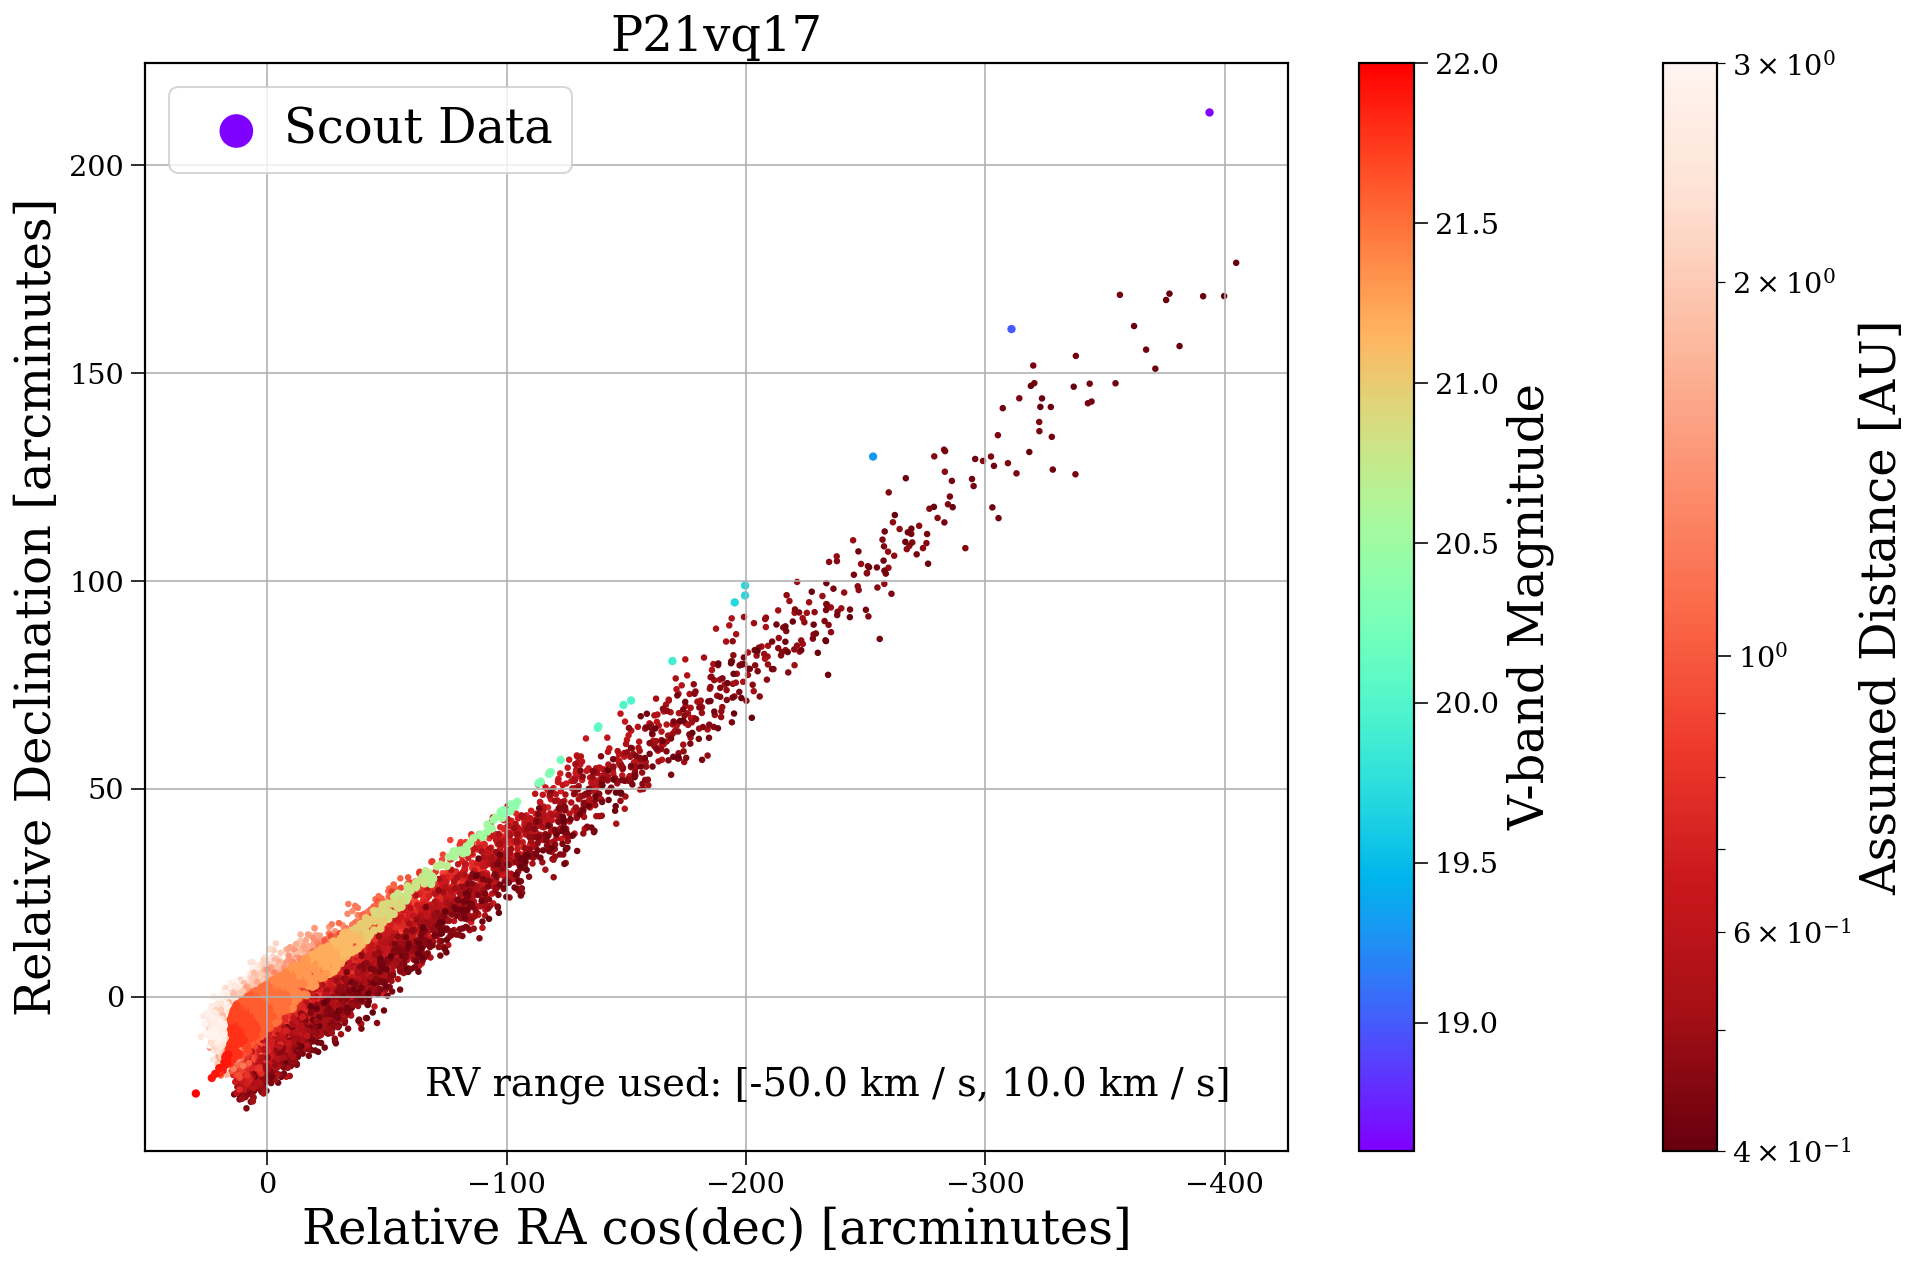

In [386]:
df, scout_eph, nominal = create_scout_comparison_plot("2022-08-03", "23:00:00", des="P21vq17",
                             sigma_ra=1 * u.arcsecond, sigma_dec=1 * u.arcsecond,
                             distances=np.logspace(np.log10(4e-1), np.log10(3), 500) * u.AU,
                             radial_velocities=np.linspace(-50, 10, 20) * u.km / u.s)

# Check against Scout

In [332]:
with urllib.request.urlopen("https://ssd-api.jpl.nasa.gov/scout.api?tdes=P21vBEn&file=mpc") as url:
    file = json.loads(url.read().decode())["fileMPC"]
    
    scout_times = []
    scout_coords = []

    for line in file.split("\n"):
        if line.rstrip() != "":
            date = line[15:32].split()
            obstime = Time(date[0] + "-" + date[1] + "-" + date[2].split(".")[0]) + float("0." + date[2].split(".")[1])
            scout_times.append(obstime)

            scout_coords.append(SkyCoord(ra=line[32:44], dec=line[44:56], unit=(u.hourangle, u.deg), frame="icrs"))

    scout_delta_t = (scout_times[-1] - scout_times[0]).to(u.day)

In [340]:
with urllib.request.urlopen("https://ssd-api.jpl.nasa.gov/scout.api?tdes=P21vBEn&eph-start=2022-08-03T23:00:00&obs-code=F52") as url:
    data = json.loads(url.read().decode())
    nominal = SkyCoord(ra=float(data["eph"][0]["median"]["ra"]),
                       dec=float(data["eph"][0]["median"]["dec"]), unit="deg", frame="icrs")
    scout_eph = np.array(data["eph"][0]["data"])[:, [0, 1, 4]].astype(float)

In [12]:
df

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom
0,0,F52,59794.958333,179.535097,51.672826,-6.920875,-1.002672,128.615570,49.678237,0.990047,0.038663,18.487693,261.756544,152.949160,45.868772,-158.332764,45.866655,310.706451,1.608356,-0.575473,1.606239,46.905159,82.474861,23.343631,0.347795,62.100285,0.645438,-0.750220,0.027788,0.001559,0.020563,0.009912,0.669414,-0.762463,0.000037,274.590384
1,1,F52,59794.958333,180.453835,51.399169,-7.181275,-0.859064,128.223052,50.075114,0.990447,0.038356,18.433994,263.178381,153.848030,45.971026,-157.433894,45.968909,310.689893,1.597679,-0.592031,1.595563,46.552602,82.474861,-12.859070,0.422400,139.641105,0.645485,-0.750714,0.027615,0.001521,0.020523,0.009915,0.669414,-0.762463,0.000037,274.241636
2,2,F52,59794.958333,181.140539,51.606222,-7.411000,-0.858471,127.752012,50.549996,0.990900,0.038024,18.371997,263.392455,154.181589,46.386052,-157.100334,46.383935,310.691544,1.594193,-0.590380,1.592077,46.078704,82.474861,-12.859070,0.422400,139.970399,0.645804,-0.751040,0.027567,0.001531,0.020513,0.009941,0.669414,-0.762463,0.000037,274.400302
3,3,F52,59794.958333,181.592672,51.644036,-7.616680,-0.837487,127.492146,50.821345,0.991280,0.037635,18.326398,263.725285,154.482658,46.579023,-156.799266,46.576906,310.692644,1.582352,-0.589280,1.580235,45.815173,82.474861,-12.859070,0.422400,140.093717,0.646069,-0.751319,0.027373,0.001531,0.020512,0.009941,0.669414,-0.762463,0.000037,274.411454
4,4,F52,59794.958333,182.214029,51.712265,-7.851093,-0.804549,127.119942,51.201353,0.991695,0.037276,18.272254,264.148977,154.882801,46.858031,-156.399123,46.855915,310.692079,1.573808,-0.589845,1.571691,45.444291,82.474861,-12.859070,0.422400,140.278878,0.646335,-0.751644,0.027237,0.001532,0.020503,0.009952,0.669414,-0.762463,0.000037,274.441510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,F52,59794.958333,312.216079,-32.955174,-1.724405,1.619339,5.062095,164.375210,3.097120,2.107909,24.511125,313.200258,305.633560,-14.589764,-5.648363,-14.591880,307.509078,-9.870934,-3.772845,-9.873051,-75.493772,82.474861,-12.859070,0.422400,66.137789,1.857880,-2.420442,-0.530937,0.010542,-0.062588,0.062053,0.669414,-0.762463,0.000037,-5672.282172
9996,9996,F52,59794.958333,312.281185,-33.021830,-1.717800,1.608506,5.060074,164.313857,3.110215,2.121255,24.533879,313.118090,305.668760,-14.668917,-5.613163,-14.671034,307.525192,-9.944851,-3.756731,-9.946967,-75.469279,82.474861,-12.859070,0.422400,66.064105,1.865998,-2.429604,-0.537135,0.010476,-0.062645,0.062041,0.669414,-0.762463,0.000037,-5672.282172
9997,9997,F52,59794.958333,312.222571,-33.000695,-1.725177,1.613078,5.030989,164.330401,3.124933,2.135976,24.557524,313.076726,305.625976,-14.635017,-5.655948,-14.637134,307.487700,-9.944168,-3.794224,-9.946285,-75.459225,82.474861,-12.859070,0.422400,66.091955,1.873235,-2.442332,-0.539640,0.010238,-0.063342,0.062713,0.669414,-0.762463,0.000037,-5672.282172
9998,9998,F52,59794.958333,312.223510,-33.049389,-1.725960,1.605822,5.023915,164.281992,3.138746,2.150002,24.580918,312.934906,305.612850,-14.682034,-5.669073,-14.684151,307.470970,-9.997273,-3.810953,-9.999390,-75.419374,82.474861,-12.859070,0.422400,66.043635,1.880492,-2.453278,-0.544890,0.009993,-0.063701,0.062890,0.669414,-0.762463,0.000037,-5672.282172


In [11]:
distances = np.logspace(np.log10(6e-2), np.log10(2), 500) * u.AU
radial_velocities = np.linspace(-30, 30, 20) * u.km / u.s
D, RV = np.meshgrid(distances, radial_velocities)

df = variant_orbit_ephemerides(ra=data_coords[0].ra,
                               dec=data_coords[0].dec,
                               ra_end=data_coords[-1].ra,
                               dec_end=data_coords[-1].dec,
                               delta_t=delta_t,
                               obstime=data_times[0],
                               distances=distances,
                               sigma_ra=1 * u.arcsecond,
                               sigma_dec=1 * u.arcsecond,
                               radial_velocities=radial_velocities,
                               eph_times=np.atleast_1d(Time(nominal_df["time"][0])),
                               location="Haleakala Observatories",
                               obs_code="F52")

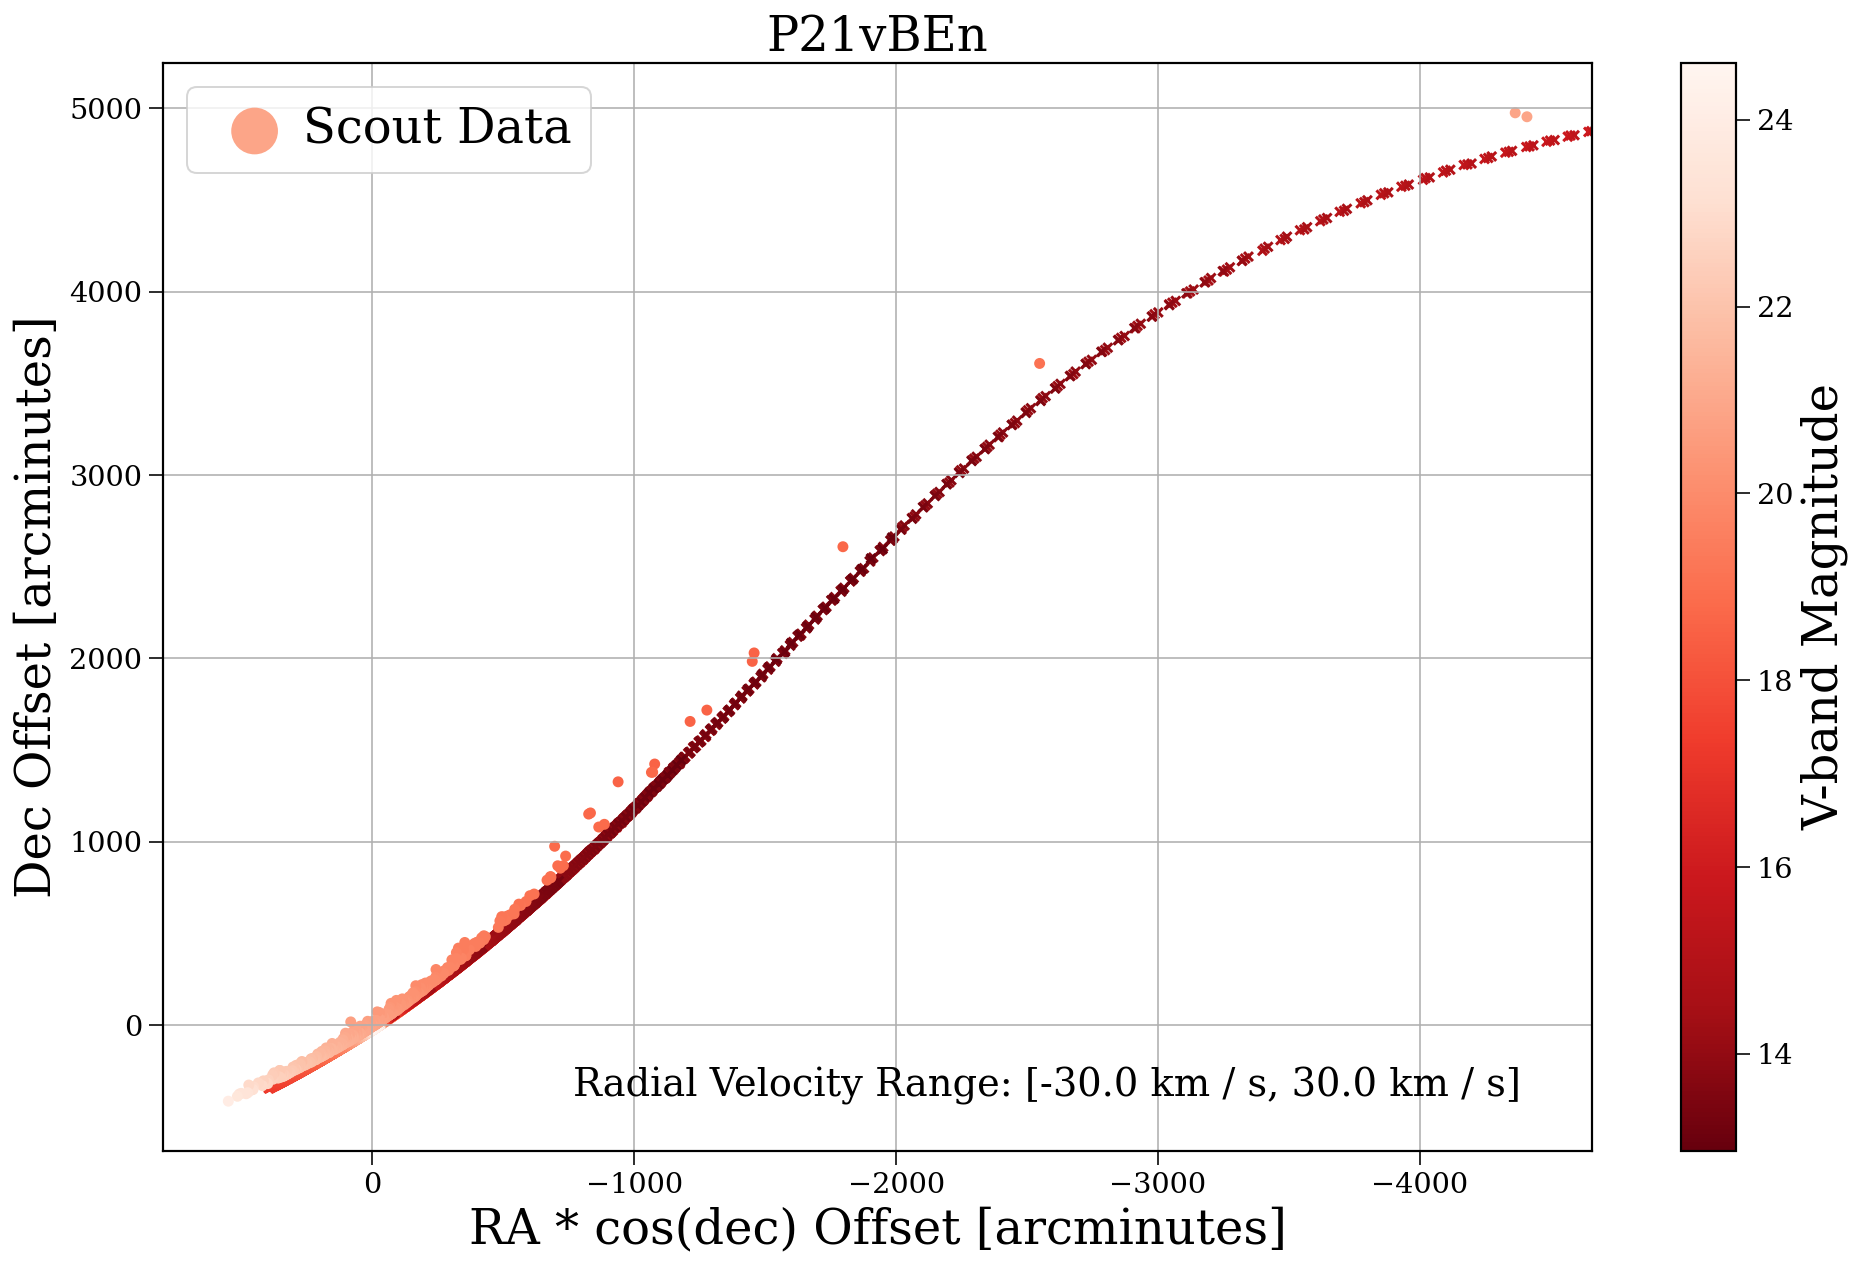

In [414]:
fig, ax = plt.subplots(figsize=(16, 10))

min_v_mag = min(df["VMag"].min(), scout_eph.T[2].min())
max_v_mag = max(df["VMag"].max(), scout_eph.T[2].max())

scatter = ax.scatter((df["RA_deg"] - nominal.ra.value) * np.cos(nominal.dec.value * u.deg) * (u.deg).to(u.arcminute),
                     (df["Dec_deg"] - nominal.dec.value) * (u.deg).to(u.arcminute),
                     s=20, c=df["VMag"], cmap="Reds_r", vmin=min_v_mag, vmax=max_v_mag,
                     marker="x")

scout   = ax.scatter((scout_eph.T[0] - nominal.ra.value) * np.cos(nominal.dec.value * u.deg) * (u.deg).to(u.arcminute),
                     (scout_eph.T[1] - nominal.dec.value) * (u.deg).to(u.arcminute),
                     s=20, c=scout_eph.T[2], cmap="Reds_r", label="Scout Data", vmin=min_v_mag, vmax=max_v_mag,
                     marker="o")

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("V-band Magnitude")

ax.set_xlabel("RA * cos(dec) Offset [arcminutes]")
ax.set_ylabel("Dec Offset [arcminutes]")

ax.set_xlim(reversed(ax.get_xlim()))

ax.annotate(f"Radial Velocity Range: [{RV.min()}, {RV.max()}]", xy=(0.95, 0.05),
            xycoords="axes fraction", ha="right", fontsize=0.8*fs)

ax.set_title(WHICH_EXAMPLE, fontsize=fs)

ax.legend(loc="upper left", handletextpad=0, markerscale=5)

ax.grid()

plt.show()

# Test code on repeated simulated observation
Here's a possible test, an object gets repeated observed by simulated LSST so I should be able to test how well the code does

In [121]:
multinight_tracklets = ["S000000Ea", "S000000Ia", "S000000pa", "S0000013a", "S000003Ea", "S0000049a", "S000003Ha"]

In [122]:
file_0 = pd.read_hdf("/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/visit-0000000.h5")
file_0["night"] = (file_0["FieldMJD"] - 0.5).astype(int)
file_0["night"] -= 59638

file_0.sort_values("FieldMJD", inplace=True)

In [123]:
def filter_observations(df, min_obs=2, min_arc=1, max_time=90):
    # create a mask based on min # of obs, min arc length, max time between shortest pair
    mask = df.groupby(["ObjID", "night"]).apply(filter_tracklets, min_obs, min_arc, max_time)

    # re-index to match the mask
    df_multiindex = df.set_index(["ObjID", "night"]).sort_index()

    # get matching items from the original df and then reset the index to what it was
    df = df_multiindex.loc[mask[mask].index].reset_index()
    return df


def filter_tracklets(df, min_obs=2, min_arc=1, max_time=90):
    init = SkyCoord(ra=df["AstRA(deg)"].iloc[0], dec=df["AstDec(deg)"].iloc[0], unit="deg")
    final = SkyCoord(ra=df["AstRA(deg)"].iloc[-1], dec=df["AstDec(deg)"].iloc[-1], unit="deg")

    return np.logical_and.reduce((len(df) >= min_obs,
                                  init.separation(final).to(u.arcsecond).value > min_arc,
                                  df["FieldMJD"].diff().min() * 1440 < max_time))

In [124]:
filtered_file_0 = filter_observations(file_0)

In [125]:
filtered_file_0

,ObjID,night,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),Ast-Sun(J2000z)(km),Ast-Sun(J2000vx)(km/s),Ast-Sun(J2000vy)(km/s),Ast-Sun(J2000vz)(km/s),Obs-Sun(J2000x)(km),Obs-Sun(J2000y)(km),Obs-Sun(J2000z)(km),Obs-Sun(J2000vx)(km/s),Obs-Sun(J2000vy)(km/s),Obs-Sun(J2000vz)(km/s),Sun-Ast-Obs(deg),V,V(H=0),fiveSigmaDepth,filter,MaginFilterTrue,AstrometricSigma(mas),PhotometricSigma(mag),SNR,AstrometricSigma(deg),MaginFilter,dmagDetect,dmagVignet,AstRATrue(deg),AstDecTrue(deg),detectorID
0,S000000Ca,16,8054.0,59655.356453,1.126948e+08,-4.022233,190.700775,-2.363694,-69.116475,-1.183400,-1.880235e+08,1.047850e+06,-1.016046e+08,20.559096,-3.830073,-17.710583,-1.485499e+08,8.507032e+06,3.686911e+06,-2.020502,-27.617846,-11.865505,41.236041,15.775590,1.775590,21.656573,y,15.369590,10.062363,0.002006,540.683429,0.000003,15.371294,0.465172,0.004180,190.700771,-69.116476,143
1,S000000Ca,16,8076.0,59655.366415,1.126914e+08,-4.007593,190.677202,-2.364353,-69.128261,-1.182258,-1.880058e+08,1.044554e+06,-1.016199e+08,20.561296,-3.830085,-17.709394,-1.485516e+08,8.483269e+06,3.676699e+06,-2.000551,-27.597704,-11.865660,41.239386,15.775532,1.775532,21.803091,y,15.369532,10.041381,0.001863,582.369716,0.000003,15.367926,0.550970,0.004255,190.677221,-69.128259,143
2,S000000Ea,1,826.0,59640.013625,5.018818e+08,20.863156,103.388801,-0.078332,14.624177,0.063618,-2.526941e+08,5.165124e+08,1.458219e+08,-7.369352,-6.162931,0.251096,-1.402445e+08,4.408881e+07,1.910791e+07,-10.546834,-25.996275,-11.257209,12.285383,20.417427,6.355427,23.947262,r,20.162427,10.678139,0.008864,121.987212,0.000003,20.182736,0.005982,0.000551,103.388804,14.624179,140
3,S000000Ea,1,848.0,59640.024891,5.019022e+08,20.893477,103.387924,-0.078315,14.624891,0.063542,-2.527013e+08,5.165064e+08,1.458221e+08,-7.369195,-6.163250,0.251006,-1.402547e+08,4.406349e+07,1.909695e+07,-10.538399,-26.026445,-11.257981,12.287111,20.417572,6.355572,23.568375,i,19.962572,10.923534,0.010079,107.223806,0.000003,19.962193,0.005614,0.000534,103.387922,14.624895,140
4,S000000Ea,1,876.0,59640.038787,5.019273e+08,20.931125,103.386833,-0.078265,14.625779,0.063447,-2.527101e+08,5.164990e+08,1.458224e+08,-7.369002,-6.163645,0.250895,-1.402674e+08,4.403222e+07,1.908344e+07,-10.525232,-26.063265,-11.258939,12.289242,20.417751,6.355751,22.281472,y,20.011751,14.531782,0.028743,37.275999,0.000004,20.051572,0.008039,0.000513,103.386834,14.625778,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571,S00018cYa,1,1265.0,59640.222410,2.472294e+07,-4.398915,147.170249,-2.118359,-29.704377,2.258252,-1.584760e+08,5.525769e+07,6.653877e+06,-6.621464,-17.717688,0.703829,-1.404316e+08,4.361557e+07,1.890471e+07,-10.118079,-26.397891,-11.272024,34.520709,22.742905,-2.229095,24.441815,r,22.487905,17.136401,0.037453,28.492435,0.000005,22.497432,1.414673,0.084741,147.170244,-29.704375,170
7572,S00018cYa,1,1314.0,59640.246580,2.471382e+07,-4.331774,147.119133,-2.111130,-29.649687,2.266668,-1.584899e+08,5.522068e+07,6.655347e+06,-6.612196,-17.720917,0.703440,-1.404527e+08,4.356043e+07,1.888117e+07,-10.045268,-26.408644,-11.273779,34.494779,22.741386,-2.230614,23.925980,i,22.286386,20.932775,0.048916,21.699861,0.000006,22.208665,1.409373,0.035186,147.119128,-29.649692,24
7573,S00018cYa,1,1315.0,59640.247053,2.471364e+07,-4.330496,147.118121,-2.110969,-29.648615,2.266828,-1.584901e+08,5.521996e+07,6.655375e+06,-6.612015,-17.720980,0.703432,-1.404531e+08,4.355935e+07,1.888071e+07,-10.043834,-26.408762,-11.273813,34.494270,22.741356,-2.230644,23.924198,i,22.286356,21.004441,0.048989,21.666681,0.000006,22.227314,1.406506,0.094976,147.118129,-29.648619,170
7574,S00018cYa,1,1330.0,59640.254767,2.471076e+07,-4.309906,147.101862,-2.108246,-29.631114,2.269410,-1.584945e+08,5.520815e+07,6.655844e+06,-6.609057,-17.722010,0.703308,

In [128]:
filtered_file_0["nextRA"] = filtered_file_0["AstRA(deg)"].shift(-1)
filtered_file_0["nextDec"] = filtered_file_0["AstDec(deg)"].shift(-1)
filtered_file_0["nextTime"] = filtered_file_0["FieldMJD"].shift(-1)
filtered_file_0["nextNight"] = filtered_file_0["night"].shift(-1)
filtered_file_0["nextID"] = filtered_file_0["ObjID"].shift(-1)

pm_ra_ratios = np.repeat(-1.0, len(filtered_file_0))
pm_ras = np.repeat(-1.0, len(filtered_file_0))
pm_dec_ratios = np.repeat(-1.0, len(filtered_file_0))
i = 0
    
for ind, row in filtered_file_0.iterrows():
    if row["nextNight"] == row["night"] and row["nextID"] == row["ObjID"]:
        delta_t = (row["nextTime"] - row["FieldMJD"]) * u.day

        start = SkyCoord(ra=row["AstRA(deg)"], dec=row["AstDec(deg)"], frame="icrs", unit='deg')
        end = SkyCoord(ra=row["nextRA"], dec=row["nextDec"], frame="icrs", unit='deg')

        # calculate the offset in ra/dec and convert to a proper motion
        delta_ra_cosdec, delta_dec = start.spherical_offsets_to(end)
        pm_ra_cosdec, pm_dec = delta_ra_cosdec / delta_t, delta_dec / delta_t
        pm_ra = pm_ra_cosdec / np.cos((row["AstDec(deg)"] + row["nextDec"]) / 2 * u.deg)
        
        pm_ras[i] = pm_ra.value

        pm_ra_ratios[i] = pm_ra.value / row["AstRARate(deg/day)"]
        pm_dec_ratios[i] = pm_dec.value / row["AstDecRate(deg/day)"]
    
    i+= 1

In [129]:
filtered_file_0["ra_ratio"] = pm_ra_ratios
filtered_file_0["dec_ratio"] = pm_dec_ratios
filtered_file_0["my_pm_ra"] = pm_ras

In [130]:
pm_ra_mask = filtered_file_0["ra_ratio"] != -1
pm_dec_mask = filtered_file_0["dec_ratio"] != -1

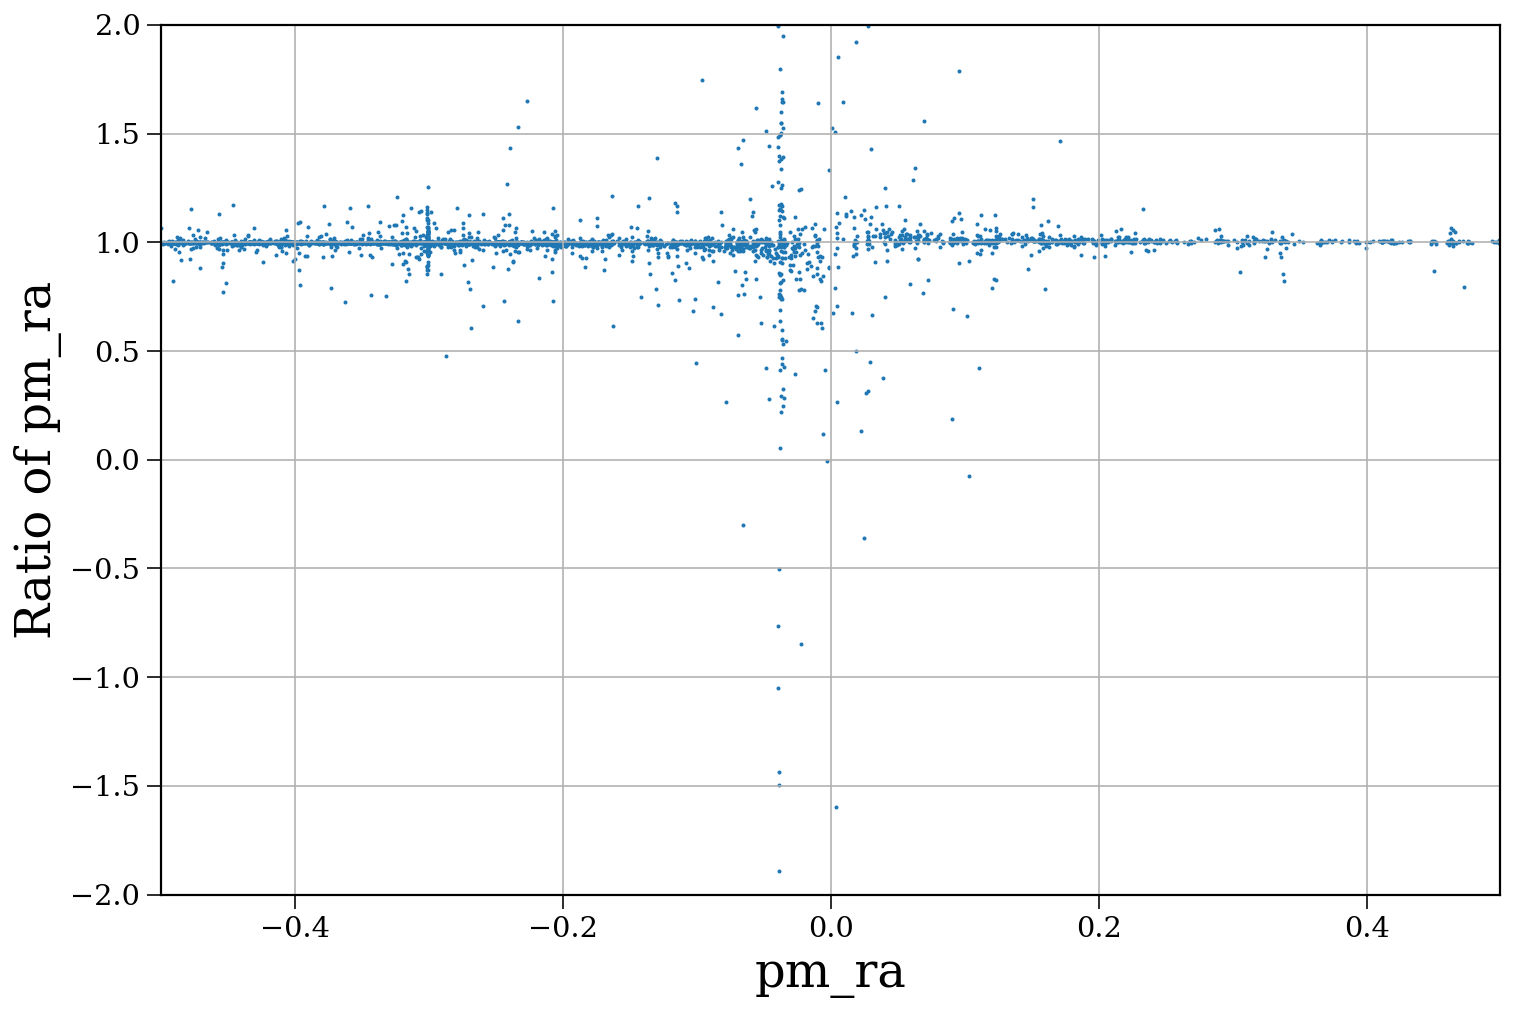

In [131]:
plt.scatter(filtered_file_0["AstRARate(deg/day)"][pm_ra_mask],
            filtered_file_0["ra_ratio"][pm_ra_mask], s=1)

plt.ylabel("Ratio of pm_ra")
plt.xlabel("pm_ra")

plt.xlim(-0.5, 0.5)
plt.ylim(-2, 2)

plt.grid()

plt.show()

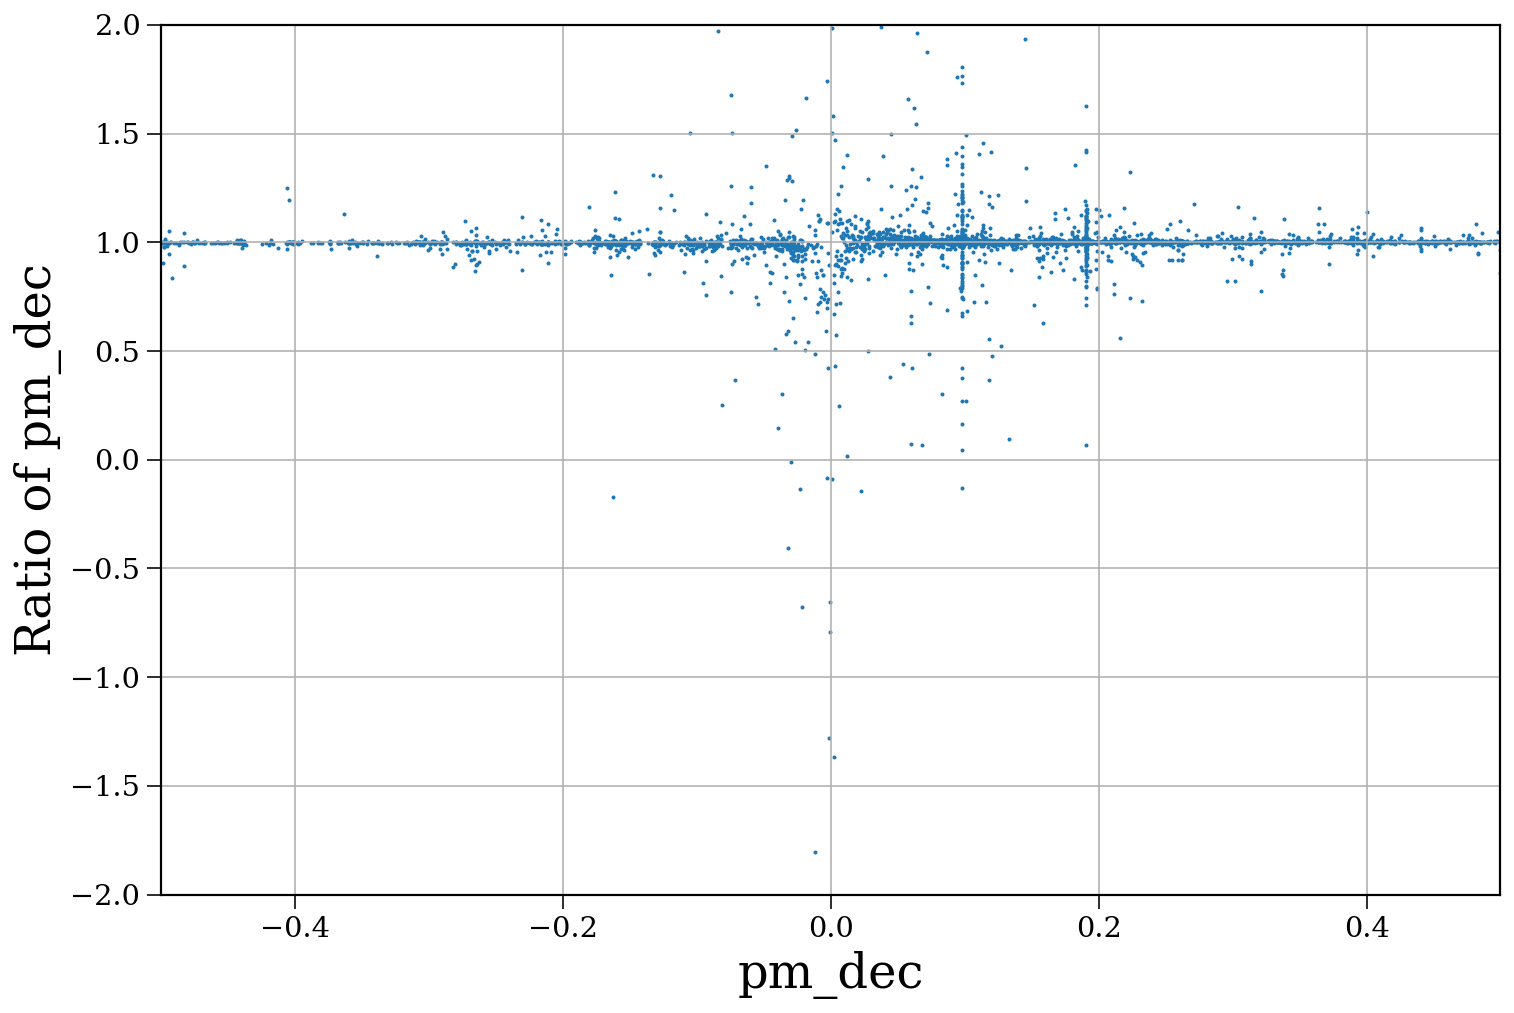

In [132]:
plt.scatter(filtered_file_0["AstDecRate(deg/day)"][pm_dec_mask],
            filtered_file_0["dec_ratio"][pm_dec_mask], s=1)

plt.ylabel("Ratio of pm_dec")
plt.xlabel("pm_dec")

plt.xlim(-0.5, 0.5)
plt.ylim(-2, 2)

plt.grid()

plt.show()

#### Problematic ones

In [460]:
filtered_file_0[np.logical_and(filtered_file_0["ra_ratio"] != -1,
                               np.logical_or(filtered_file_0["ra_ratio"] < 0.9,
                                             filtered_file_0["ra_ratio"] > 1.1))]["ObjID"].unique()

array(['S000000ua', 'S000002Aa', 'S000002Ha', 'S000005ta', 'S000006Xa',
       'S000006ka', 'S000007Ba', 'S000007Ja', 'S00000ATa', 'S00000B8a',
       'S00000Dva', 'S00000ISa', 'S00000K0a', 'S00000L1a', 'S00000Lha',
       'S00000PYa', 'S00000Pma', 'S00000Psa', 'S00000QPa', 'S00000VLa',
       'S00000XHa', 'S00000YTa', 'S00000aKa', 'S00000bca', 'S00000cCa',
       'S00000cXa', 'S00000e8a', 'S00000era', 'S00000ewa', 'S00000fwa',
       'S00000gBa', 'S00000gGa', 'S00000iYa', 'S00000k3a', 'S00000kka',
       'S00000pGa', 'S00000q4a', 'S00000sga', 'S00000wFa', 'S00000xwa',
       'S00000y6a', 'S00000yXa', 'S000011na', 'S000012Ea', 'S000012Ja',
       'S000012Za', 'S000019za', 'S00001VQa', 'S00001eDa', 'S00001f7a',
       'S00001gwa', 'S00001iia', 'S00001l6a', 'S00001m6a', 'S00001pKa',
       'S00001rka', 'S000028Ca', 'S00002Bpa', 'S00002Hsa', 'S00002Jfa',
       'S00002Kwa', 'S00002Pya', 'S00002SSa', 'S00002T4a', 'S00002Vba',
       'S00002Zxa', 'S00002eta', 'S00002pja', 'S00002r1a', 'S000

## Manual tests

In [466]:
def validate_pm_ra(df, start, end):
    approx_test = (df.loc[end]["AstRA(deg)"] - df.loc[start]["AstRA(deg)"]) / (df.loc[end]["FieldMJD"] - df.loc[start]["FieldMJD"])
    approx_test_new = (df.loc[end]["AstRATrue(deg)"] - df.loc[start]["AstRATrue(deg)"]) / (df.loc[end]["FieldMJD"] - df.loc[start]["FieldMJD"])
    print(f'Approx: {approx_test:1.6f}')
    print(f'I find: {df.loc[start]["my_pm_ra"]:1.6f}')
    print(f'File  : {df.loc[start]["AstRARate(deg/day)"]:1.6f}')
    print(f'Test  : {approx_test_new:1.6f}')

In [212]:
x.loc[98]["AstRA(deg)"]

103.26468707876

In [213]:
x.loc[99]["AstRA(deg)"]

103.26463174553697

In [468]:
x = filtered_file_0[filtered_file_0["ObjID"] == "S000002Aa"][["AstRARate(deg/day)", "my_pm_ra", "ra_ratio", "FieldMJD", "AstRA(deg)", "AstDec(deg)", "AstRATrue(deg)", "AstDecTrue(deg)", "AstDecRate(deg/day)", "dec_ratio", "Sun-Ast-Obs(deg)"]]
x

,AstRARate(deg/day),my_pm_ra,ra_ratio,FieldMJD,AstRA(deg),AstDec(deg),AstRATrue(deg),AstDecTrue(deg),AstDecRate(deg/day),dec_ratio,Sun-Ast-Obs(deg)
88,-0.093213,-0.094941,1.018535,59640.011361,103.878870,11.760711,103.878865,11.760714,0.042586,1.017651,15.398523
89,-0.093213,-0.093041,0.998163,59640.014071,103.878613,11.760828,103.878613,11.760830,0.042567,0.999881,15.399108
90,-0.093201,-0.093123,0.999159,59640.022627,103.877817,11.761193,103.877815,11.761194,0.042509,1.058715,15.400954
91,-0.093195,-0.093667,1.005071,59640.025338,103.877564,11.761315,103.877562,11.761309,0.042490,0.988148,15.401540
92,-0.093140,-0.093139,0.999985,59640.038339,103.876347,11.761861,103.876351,11.761861,0.042400,0.997635,15.404346
93,-0.092959,-1.000000,-1.000000,59640.060994,103.874237,11.762819,103.874243,11.762820,0.042244,-1.000000,15.409233
94,-0.011618,-0.012588,1.083478,59653.000451,103.268472,12.289642,103.268461,12.289635,0.038405,0.953818,17.675122
95,-0.011549,-0.011355,0.983160,59653.011239,103.268336,12.290037,103.268336,12.290049,0.038327,0.996481,17.676686
96,-0.010541,-0.009313,0.883513,59653.080872,103.267545,12.292696,103.267562,12.292700,0.037845,1.017312,17.686758
97,-0.010018,-1.000000,-1.000000,59653.103414,103.267335,12.293564,103.267330,12.293552,0.037706,-1.000000,17.690001


It *seems* like the file could be wrong?

In [469]:
validate_pm_ra(x, 98, 99)

Approx: -0.123901
I find: -0.123901
File  : -0.004492
Test  : -0.004488


In [470]:
validate_pm_ra(x, 99, 100)

Approx: -0.001848
I find: -0.001848
File  : -0.004483
Test  : -0.004239


In [471]:
validate_pm_ra(x, 100, 101)

Approx: -0.098796
I find: -0.098796
File  : -0.003981
Test  : -0.003976


# Plot tracks

In [61]:
multinight_tracklets = ["S000000Ea", "S000000Ia", "S000000pa", "S0000013a",
                        "S000003Ea", "S0000049a", "S000003Ha", "S000181Da"]

S000000Ea 0.04781813839508686 d
S000000Ia 0.02334147104556905 d
S000000pa 0.02397540349920746 d
S0000013a 0.02383582483162172 d
S000003Ea 0.011581649479921907 d
S0000049a 0.024336679955013096 d
S000003Ha 0.07576605664507952 d
S000181Da 0.024536179495044053 d


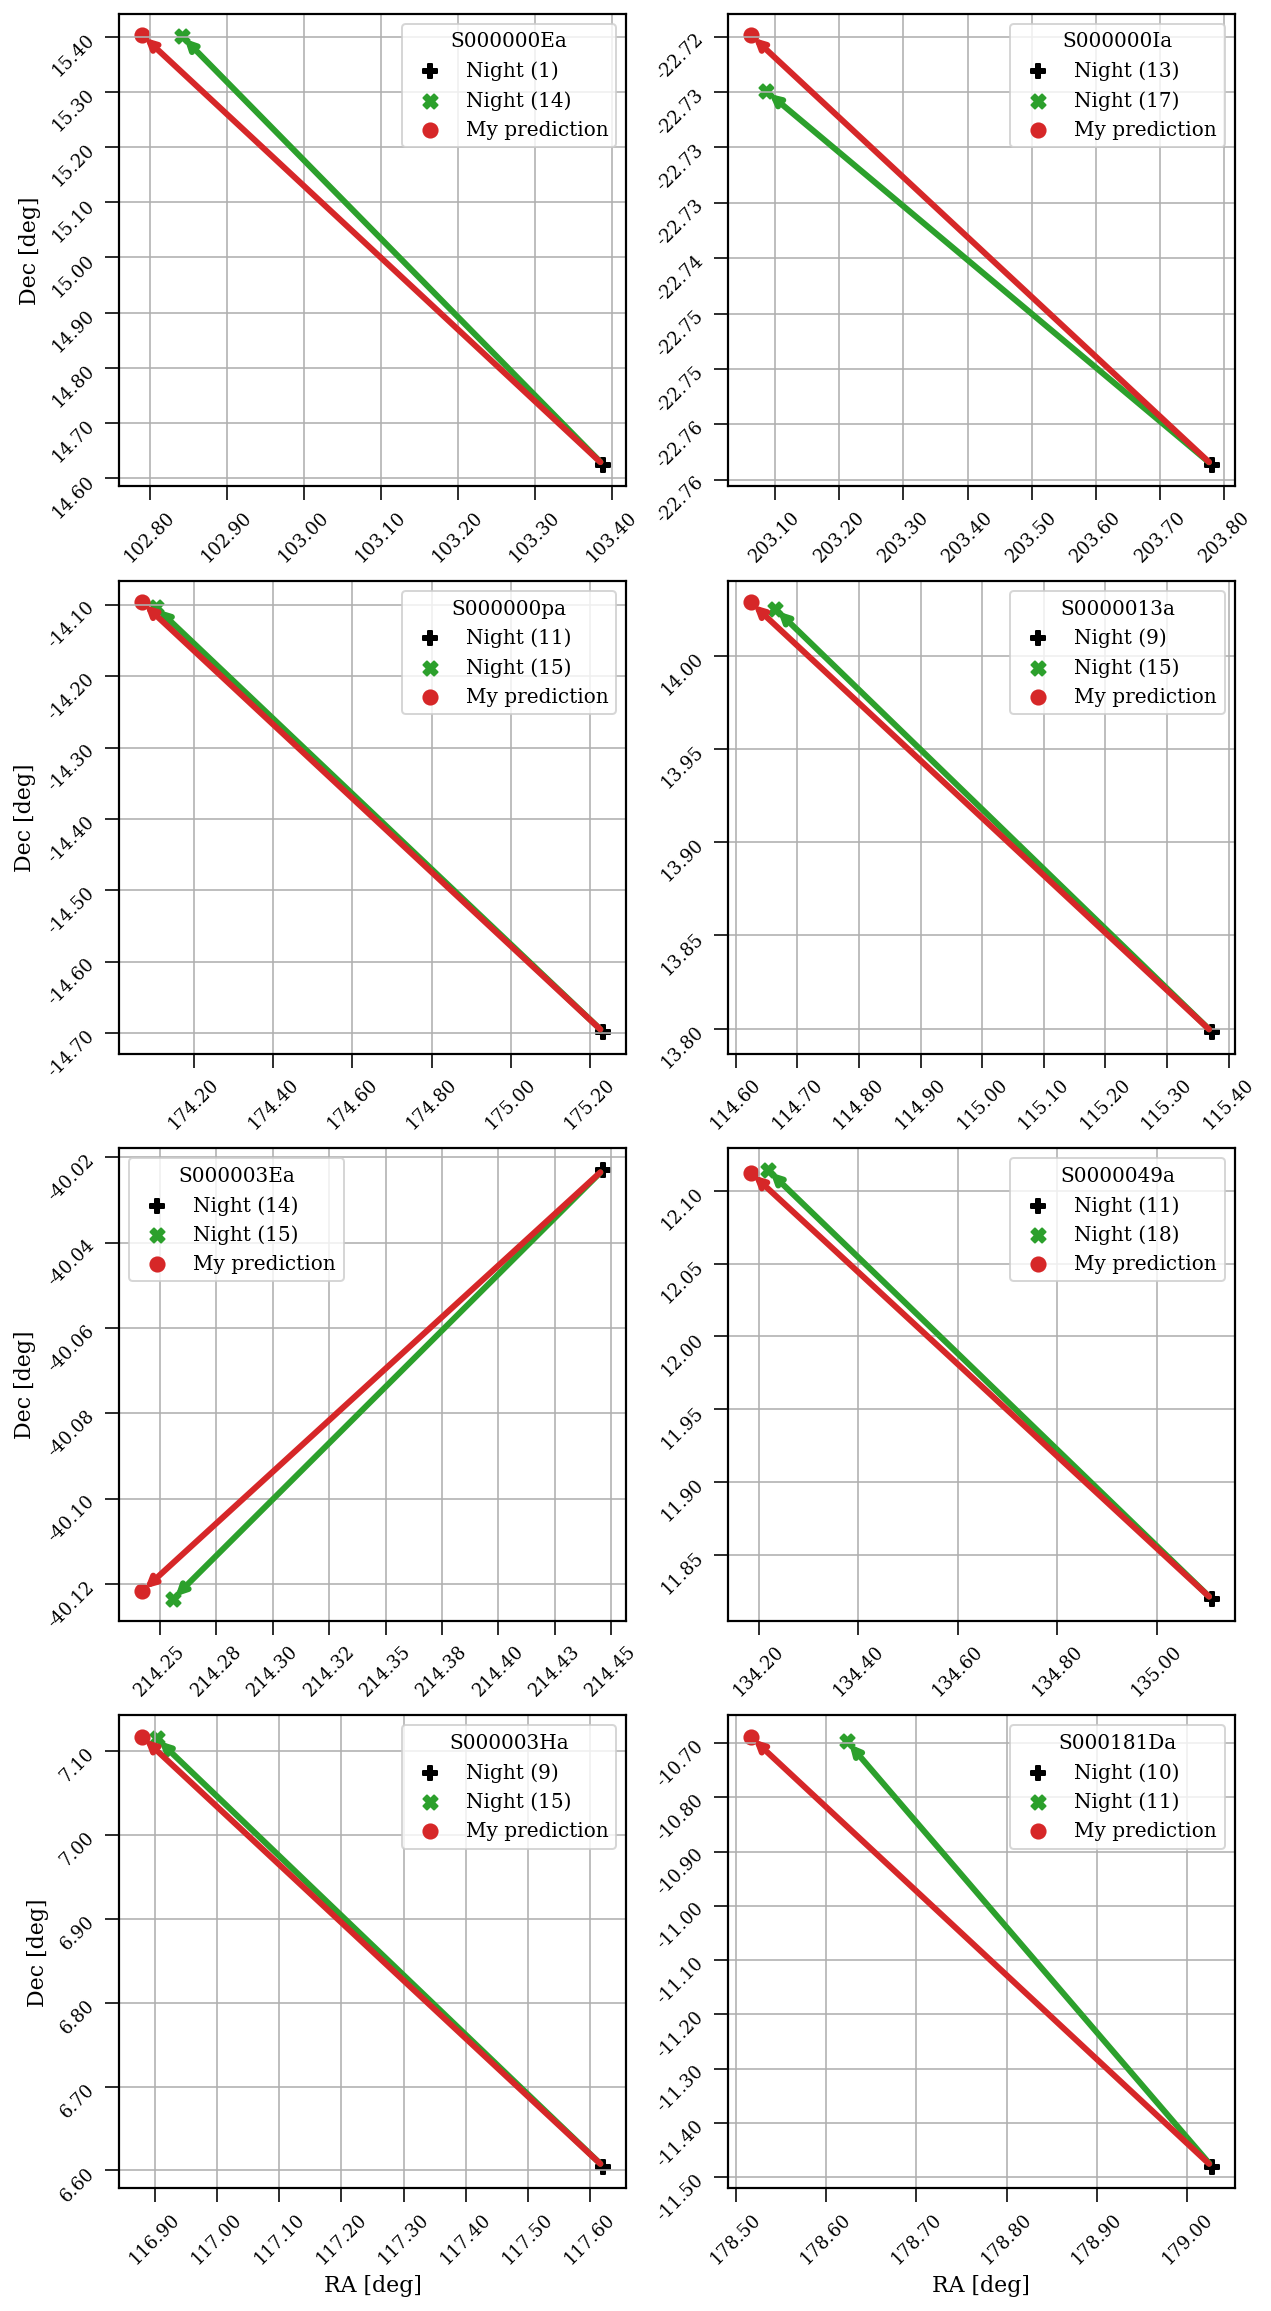

In [144]:
fig, axes = plt.subplots(4, 2, figsize=(2 * 5, 4 * 5))

for objid, ax in zip(multinight_tracklets, axes.flatten()):
    rows = filtered_file_0[filtered_file_0["ObjID"] == objid]
    nights = rows["night"].unique()
    
    start = rows["night"] == nights[0]
    end = rows["night"] == nights[1]
    delta_t = (rows[start]["FieldMJD"].iloc[-1] - rows[start]["FieldMJD"].iloc[0]) * u.day
        
    df = variant_orbit_ephemerides(ra=rows[start].iloc[0]["AstRA(deg)"] * u.deg,
                                   dec=rows[start].iloc[0]["AstDec(deg)"] * u.deg,
                                   ra_end=rows[start].iloc[-1]["AstRA(deg)"] * u.deg,
                                   dec_end=rows[start].iloc[-1]["AstDec(deg)"] * u.deg,
                                   delta_t=delta_t,
                                   obstime=Time(rows[start]["FieldMJD"].iloc[0], format="mjd"),
                                   distances=[rows[start]["AstRange(km)"].iloc[0]] * u.km,
                                   sigma_ra=0.0 * u.arcsecond,
                                   sigma_dec=0.0 * u.arcsecond,
                                   radial_velocities=[rows[start]["AstRangeRate(km/s)"].iloc[0]] * u.km / u.s,
                                   emph_times=np.atleast_1d(Time(rows[end]["FieldMJD"].iloc[0], format="mjd")),
                                   location="Gemini South",
                                   obs_co)

    ax.scatter(rows[start].iloc[0]["AstRA(deg)"], rows[start].iloc[0]["AstDec(deg)"],
               s=50, marker="P", color="black", label=f"Night ({nights[0]})")
    ax.scatter(rows[end].iloc[0]["AstRA(deg)"], rows[end].iloc[0]["AstDec(deg)"],
               s=50, marker="X", color="tab:green", label=f"Night ({nights[1]})")
    scatter = ax.scatter(df["RA_deg"], df["Dec_deg"],
                         s=50, color="tab:red", label="My prediction")
    
    ax.annotate("", xy=(rows[end].iloc[0]["AstRA(deg)"],
                        rows[end].iloc[0]["AstDec(deg)"]),
                xytext=(rows[start].iloc[0]["AstRA(deg)"],
                        rows[start].iloc[0]["AstDec(deg)"]),
                arrowprops=dict(arrowstyle="->", linewidth=3, color="tab:green"))
    
    ax.annotate("", xy=(df["RA_deg"], df["Dec_deg"]),
                xytext=(rows[start].iloc[0]["AstRA(deg)"],
                        rows[start].iloc[0]["AstDec(deg)"]),
                arrowprops=dict(arrowstyle="->", linewidth=3, color="tab:red"))

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax.tick_params(axis="x", which="both", labelsize=9, rotation=45)
    ax.tick_params(axis="y", which="both", labelsize=9, rotation=45)

    ax.legend(fontsize=10, title=objid)

    ax.grid()
    print(objid, delta_t)


for ax in axes[-1, :]:
    ax.set_xlabel("RA [deg]", fontsize=11)
    
for ax in axes[:, 0]:
    ax.set_ylabel("Dec [deg]", fontsize=11)
    
plt.show()

In [96]:
filtered_file_0[filtered_file_0["ObjID"].isin(multinight_tracklets)].groupby(["ObjID", "night"]).first()

FieldID      FieldMJD  AstRange(km)  AstRangeRate(km/s)  \
ObjID     night                                                            
S000000Ea 1        826.0  59640.013625  5.018818e+08           20.863156   
          14      5502.0  59653.000006  5.269403e+08           23.455255   
S000000Ia 13      5339.0  59652.335013  4.621909e+08          -15.956967   
          17      8907.0  59656.330887  4.569322e+08          -14.244500   
S000000pa 11      3531.0  59650.295775  2.558555e+08          -16.693887   
          15      7068.0  59654.320613  2.503370e+08          -14.574186   
S0000013a 9       1703.0  59648.033141  3.234602e+08           19.996807   
          15      6381.0  59653.999178  3.341613e+08           21.329331   
          16      7439.0  59655.074328  3.361602e+08           21.727239   
S000003Ea 14      6294.0  59653.371834  4.040211e+08          -18.997689   
          15      7171.0  59654.367203  4.023904e+08          -18.704513   
S000003Ha 9       1699.0  59648.031352  5.224537e+08           21.421418   
          15      6399.0  59654.008573  5.340358e+08           23.225368   
S0000049a 11      3251.0  59650.163762  4.372869e+08           18.131466   
          18      9143.0  59657.022896  4.487335e+08           20.444574   
S000181Da 10      2594.0  59649.257454  2.125907e+07          -27.157791   
          11      3534.0  59650.297196  1.881990e+07          -26.895058   
          13      5359.0  59652.344868  1.406255e+07          -26.399238   

                 AstRA(deg)  AstRARate(deg/day)  AstDec(deg)  \
ObjID     night                                                
S000000Ea 1      103.388801           -0.078332    14.624177   
          14     102.841743           -0.014323    15.401559   
S000000Ia 13     203.780701           -0.170634   -22.758658   
          17     203.086472           -0.185424   -22.724937   
S000000pa 11     175.233699           -0.281898   -14.698718   
          15     174.103070           -0.291944   -14.102947   
S0000013a 9      115.372974           -0.148454    13.798121   
          15     114.663883           -0.101846    14.025192   
          16     114.564759           -0.093566    14.062147   
S000003Ea 14     214.446516           -0.194264   -40.022857   
          15     214.255551           -0.201467   -40.123602   
S000003Ha 9      117.621250           -0.138352     6.604677   
          15     116.902793           -0.109486     7.115013   
S0000049a 11     135.110201           -0.150362    11.819485   
          18     134.218191           -0.118117    12.114455   
S000181Da 10     179.027120           -0.432596   -11.480325   
          11     178.623111           -0.531597   -10.696687   
          13     177.421900           -0.875780    -8.322913   

                 AstDecRate(deg/day)  Ast-Sun(J2000x)(km)  \
ObjID     night                                             
S000000Ea 1                 0.063618        -2.526941e+08   
          14                0.055959        -2.608594e+08   
S000000Ia 13                0.004447        -5.377566e+08   
          17                0.013574        -5.364338e+08   
S000000pa 11                0.139428        -3.935871e+08   
          15                0.158789        -3.898247e+08   
S0000013a 9                 0.041316        -2.804848e+08   
          15                0.035237        -2.835193e+08   
          16                0.033404        -2.840524e+08   
S000003Ea 14               -0.101393        -4.032048e+08   
          15               -0.098683        -4.026449e+08   
S000003Ha 9                 0.087537        -3.864929e+08   
          15                0.083209        -3.880144e+08   
S0000049a 11                0.046273        -4.501383e+08   
          18                0.039566        -4.547980e+08   
S000181Da 10                0.665627        -1.673251e+08   
          11                0.865486        -1.654488e+08   
          13                1.575875        -1.616410e+0

# Below is not relevant, just wanted a plot

In [178]:
import pandas as pd

In [179]:
hybrid = pd.read_hdf("../catalogues/hybrid.h5")

In [182]:
a = hybrid["q"] / (1 - hybrid["e"])

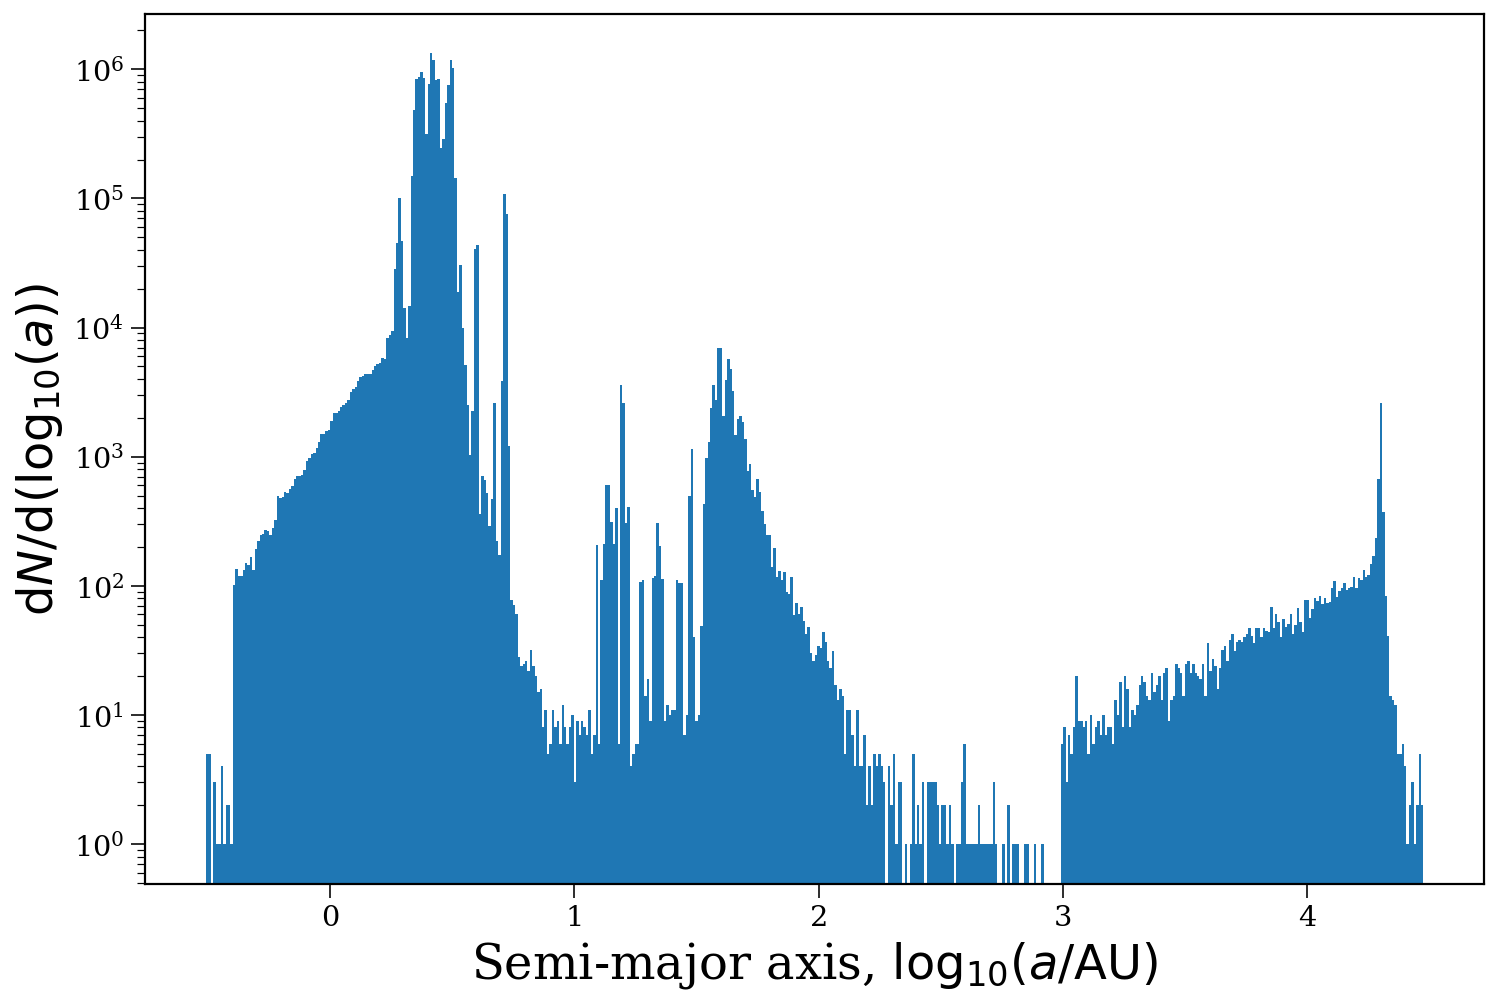

In [206]:
fig, ax = plt.subplots()

ax.hist(np.log10(a), bins=500, log=True)

# for distance in [1, 3, 45]:
#     ax.axvline(np.log10(distance), color="grey", linestyle="dotted")
#     ax.

ax.set_xlabel(r"Semi-major axis, $\log_{10}(a / \rm{AU})$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}(\log_{10}(a))$")

plt.show()